# Download and Prepare Kaggle Dataset

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d chenghanpu/brain-tumor-mri-and-ct-scan

Saving kaggle.json to kaggle.json
100% 3.43G/3.43G [02:56<00:00, 23.8MB/s]
100% 3.43G/3.43G [02:56<00:00, 20.9MB/s]


In [ ]:
!mkdir kaggle_dicom_data

In [ ]:
!unzip /content/brain-tumor-mri-and-ct-scan.zip -d kaggle_dicom_data

Streaming output truncated to the last 5000 lines.
  inflating: kaggle_dicom_data/dicom/4/ACRIN-FMISO-Brain-011/MR/5.000000-AXIAL T1-55433/1-28.dcm  
  inflating: kaggle_dicom_data/dicom/4/ACRIN-FMISO-Brain-011/MR/5.000000-AXIAL T1-55433/1-29.dcm  
  inflating: kaggle_dicom_data/dicom/4/ACRIN-FMISO-Brain-011/MR/5.000000-AXIAL T1-55433/1-30.dcm  
  inflating: kaggle_dicom_data/dicom/4/ACRIN-FMISO-Brain-011/MR/5.000000-AXIAL T1-55433/1-31.dcm  
  inflating: kaggle_dicom_data/dicom/4/ACRIN-FMISO-Brain-011/MR/5.000000-AXIAL T1-55433/1-32.dcm  
  inflating: kaggle_dicom_data/dicom/4/ACRIN-FMISO-Brain-011/MR/5.000000-AXIAL T1-55433/1-33.dcm  
  inflating: kaggle_dicom_data/dicom/4/ACRIN-FMISO-Brain-011/MR/5.000000-AXIAL T1-80746/1-01.dcm  
  inflating: kaggle_dicom_data/dicom/4/ACRIN-FMISO-Brain-011/MR/5.000000-AXIAL T1-80746/1-02.dcm  
  inflating: kaggle_dicom_data/dicom/4/ACRIN-FMISO-Brain-011/MR/5.000000-AXIAL T1-80746/1-03.dcm  
  inflating: kaggle_dicom_data/dicom/4/ACRIN-FMISO-Brain-0

In [ ]:
!pip install pydicom
!pip install dicom_numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.2 MB/s eta 0:00:00


In [ ]:
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import imageio


import os, glob, shutil
import numpy as np
import matplotlib.pyplot as plt # for 2D plot

from tqdm import tqdm # for confirming loop progress
from pydicom import dcmread # for reading the given dicom data
from skimage import measure # for 3D plot (1)
from mpl_toolkits.mplot3d.art3d import Poly3DCollection # for 3D plot (2)

In [ ]:
import glob

all_ct = (glob.glob("/content/kaggle_dicom_data/dicom/*/*/*/*/*/*.dcm"))
all_mr = (glob.glob("/content/kaggle_dicom_data/dicom/*/*/*/*/*.dcm"))
print(len(all_ct), len(all_mr))

4478 11970


In [ ]:
# read a sample MR image

mr_im = imageio.imread(all_mr[200])
mr_im.meta

<ipython-input-7-9833d602b66b>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mr_im = imageio.imread(all_mr[200])


Dict([('TransferSyntaxUID', '1.2.840.10008.1.2.1'),
      ('SOPClassUID', '1.2.840.10008.5.1.4.1.1.4'),
      ('SOPInstanceUID',
       '1.3.6.1.4.1.14519.5.2.1.7009.2402.145314360656007890738443814938'),
      ('StudyDate', '19600531'),
      ('SeriesDate', '19600531'),
      ('AcquisitionDate', '19600531'),
      ('ContentDate', '19600531'),
      ('StudyTime', '085745'),
      ('SeriesTime', '092229.79000'),
      ('AcquisitionTime', '092229.79 '),
      ('ContentTime', '092229.79 '),
      ('Modality', 'MR'),
      ('Manufacturer', 'Philips Medical Systems'),
      ('StudyDescription', 'TUMOR'),
      ('SeriesDescription', 'AX T1 3D TFE POST'),
      ('PatientName', 'ACRIN-FMISO-Brain-031'),
      ('PatientID', 'ACRIN-FMISO-Brain-031'),
      ('PatientBirthDate', ''),
      ('PatientSex', 0.0),
      ('PatientAge', '059Y'),
      ('PatientWeight', 77.0),
      ('SliceSpacing', 1.6),
      ('StudyInstanceUID',
       '1.3.6.1.4.1.14519.5.2.1.7009.2402.205473561892968169230288179835'

In [ ]:
# load a sample CT image

ct_im = imageio.imread(all_ct[100])
ct_im.meta

<ipython-input-8-e76389ee76b3>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ct_im = imageio.imread(all_ct[100])


Dict([('TransferSyntaxUID', '1.2.840.10008.1.2.1'),
      ('SOPClassUID', '1.2.840.10008.5.1.4.1.1.2'),
      ('SOPInstanceUID',
       '1.3.6.1.4.1.14519.5.2.1.7009.2402.333356659286350988121698355810'),
      ('StudyDate', '19600102'),
      ('SeriesDate', '19600102'),
      ('AcquisitionDate', '19600102'),
      ('ContentDate', '19600102'),
      ('StudyTime', '151137'),
      ('SeriesTime', '151228'),
      ('AcquisitionTime', '151444'),
      ('ContentTime', '151512'),
      ('Modality', 'CT'),
      ('Manufacturer', 'GE MEDICAL SYSTEMS'),
      ('StudyDescription', 'PET RESEARCH'),
      ('SeriesDescription', 'CT 2.5MM STD'),
      ('PatientName', 'ACRIN-FMISO-Brain-029'),
      ('PatientID', 'ACRIN-FMISO-Brain-029'),
      ('PatientBirthDate', ''),
      ('PatientSex', 'M '),
      ('PatientAge', '068Y'),
      ('PatientSize', 1.9),
      ('PatientWeight', 98.0),
      ('StudyInstanceUID',
       '1.3.6.1.4.1.14519.5.2.1.7009.2402.584634039594961433978453722889'),
      ('Series

In [ ]:
mr_im.meta['Modality'], ct_im.meta['Modality']

('MR', 'CT')

In [ ]:
mr_im.meta['PixelData']

b'Data converted to numpy array, raw data removed to preserve memory'

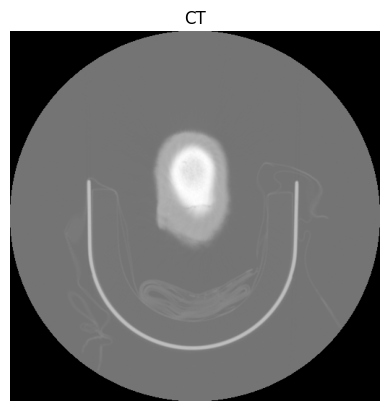

In [ ]:
#Show the image with gray color-map
plt.imshow(ct_im, cmap='gray')
#Don't show tha axes
plt.axis('off')
#Add a title to the plot
plt.title(ct_im.meta['Modality'])
plt.show()

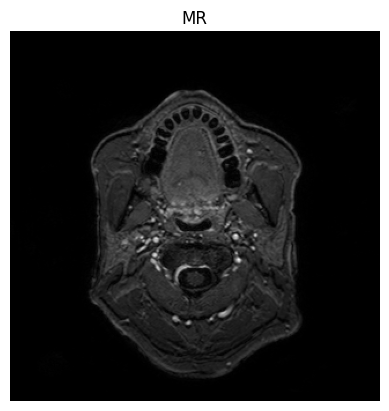

In [ ]:
#Show the image with gray color-map
plt.imshow(mr_im, cmap='gray')
#Don't show tha axes
plt.axis('off')
#Add a title to the plot
plt.title(mr_im.meta['Modality'])
plt.show()

In [ ]:
all_ct[:5]

['/content/kaggle_dicom_data/dicom/6/ACRIN-FMISO-Brain-031/CT/STD/2.000000-CTAC SLICES-17303/1-11.dcm',
 '/content/kaggle_dicom_data/dicom/6/ACRIN-FMISO-Brain-031/CT/STD/2.000000-CTAC SLICES-17303/1-18.dcm',
 '/content/kaggle_dicom_data/dicom/6/ACRIN-FMISO-Brain-031/CT/STD/2.000000-CTAC SLICES-17303/1-01.dcm',
 '/content/kaggle_dicom_data/dicom/6/ACRIN-FMISO-Brain-031/CT/STD/2.000000-CTAC SLICES-17303/1-30.dcm',
 '/content/kaggle_dicom_data/dicom/6/ACRIN-FMISO-Brain-031/CT/STD/2.000000-CTAC SLICES-17303/1-07.dcm']

# UTIL function to sort dataset and create directories

In [ ]:
def sorted_list(path):

    """ function for getting list of files or directories. """

    tmplist = glob.glob(path) # finding all files or directories and listing them.
    tmplist.sort() # sorting the found list

    return tmplist

In [ ]:
def make_dir(path, refresh=False):

    """ function for making directory (to save results). """
    import os
    import shutil

    try: os.mkdir(path)
    except:
        if(refresh):
            shutil.rmtree(path)
            os.mkdir(path)

In [ ]:
print("total CT", len(sorted_list(path=os.path.join("/content/kaggle_dicom_data/dicom/*/*/*/*/*", '*.dcm'))))
print("total MR", len(sorted_list(path=os.path.join("/content/kaggle_dicom_data/dicom/*/*/*/*", '*.dcm'))))

total CT 4478
total MR 11970


# UTIL function to load and prepare the dataset

In [ ]:
def dicom_volume1(path):

    """ function for getting DICOM volumes and convert to numpy array. """

    list_dcm = sorted_list(path=os.path.join(path, '*.dcm'))[:300] # getting all slice as a list (using 300 files in each class) because of memory consumption
    list_index = []
    for path_dcm in list_dcm:
        list_index.append(int(path_dcm.split('/')[-1].replace('-', '').replace('.dcm', ''))) # parsing and adding the index of slice
    list_index.sort() # sort the index

    list_arr = [] # array storage
    for idx_dcm in list_dcm:
        ds = dcmread(idx_dcm) # getting slice information via single DICOM file.
        arr = ds.pixel_array # extracting numpy array from DICOM file
        list_arr.append(arr) # stacking to the array storage

    return np.asarray(list_arr) # converting as numpy array

def dicom_volume(path):
    """Function for getting DICOM volumes and converting to a numpy array."""

    list_dcm = sorted_list(path=os.path.join(path, '*.dcm'))[:300] # getting all slice as a list (using 300 files in each class) because of memory consumption
    list_index = []
    for path_dcm in list_dcm:
        list_index.append(int(path_dcm.split('/')[-1].replace('-', '').replace('.dcm', ''))) # parsing and adding the index of slice
    list_index.sort() # sort the index

    volume = np.zeros((len(list_index), 512, 512, 3), dtype=np.uint16)
    for idx, path_dcm in enumerate(list_dcm):
        ds = dcmread(path_dcm)
        arr = ds.pixel_array
        volume[idx, :, :, 0] = arr  # Assign the grayscale pixel values to the first channel
        volume[idx, :, :, 1] = arr  # Assign the grayscale pixel values to the second channel
        volume[idx, :, :, 2] = arr  # Assign the grayscale pixel values to the third channel

    return volume

def plot_2d(volume, index=0, title=''):

    """ function for plotting the DICOM slice. """

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.imshow(volume[index, :, :, 0])

    plt.show()

def plot_3d(volume, threshold=0, title=''):

    """ function for plotting the DICOM volume. """

    p = volume.transpose(2,1,0)
    verts, faces, normals, values = measure.marching_cubes(p, threshold)
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(title)
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

# convert and save dataset to numpy data

In [ ]:
# convert all dicoms to numpy array

all_ct_arr = dicom_volume("/content/kaggle_dicom_data/dicom/*/*/*/*/*")
all_mr_arr = dicom_volume("/content/kaggle_dicom_data/dicom/*/*/*/*")

In [ ]:
print("CT shape", all_ct_arr.shape)
print("MRI shape", all_mr_arr.shape)

CT shape (300, 512, 512, 3)
MRI shape (300, 512, 512, 3)


In [ ]:
from numpy import savez_compressed

filename = 'mri2ct_512.npz'
savez_compressed(filename, all_ct_arr, all_mr_arr)
print('Saved dataset: ', filename)

Saved dataset:  mri2ct_512.npz


# Visualize 2D dataset

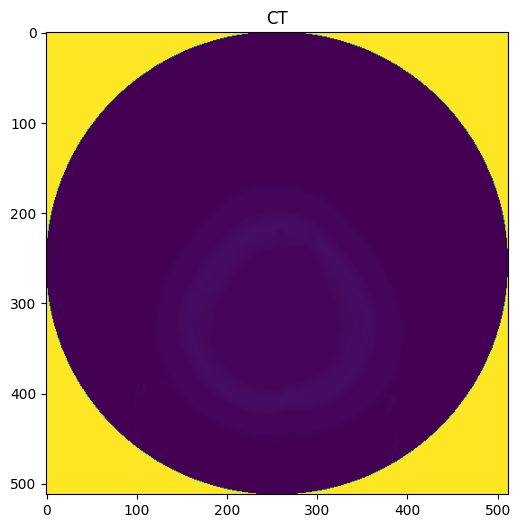

In [ ]:
# plot a single CT image from the numpy array

plot_2d(all_ct_arr, index=250, title="CT")

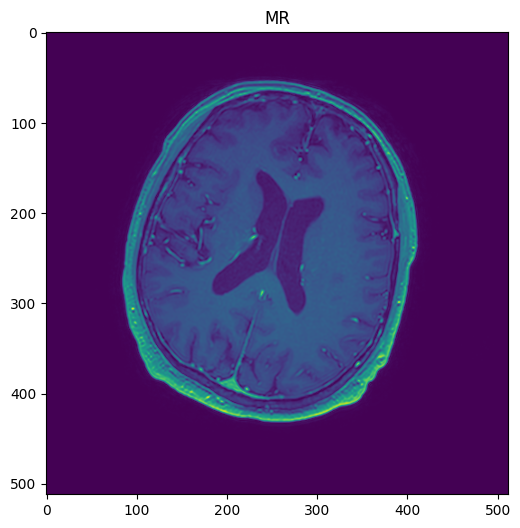

In [ ]:
plot_2d(all_mr_arr, index=250, title="MR")

# copy dataset to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/mri2ct_512.npz -d /content/drive/MyDrive

# download and PREPARE GITHUB DATASET

In [ ]:
!git clone https://github.com/DevTimlas/mri2ct-dataset.git

Cloning into 'mri2ct-dataset'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (6/6), 18.91 MiB | 8.25 MiB/s, done.


# Unpack dataset

In [ ]:
!unzip /content/mri2ct-dataset/mri2ct.zip -d /content/

Archive:  /content/mri2ct-dataset/mri2ct.zip
  inflating: /content/mri2ct/testCT/0300.png-ct.png  
  inflating: /content/mri2ct/testCT/0301.png-ct.png  
  inflating: /content/mri2ct/testCT/0302.png-ct.png  
  inflating: /content/mri2ct/testCT/0303.png-ct.png  
  inflating: /content/mri2ct/testCT/0304.png-ct.png  
  inflating: /content/mri2ct/testCT/0305.png-ct.png  
  inflating: /content/mri2ct/testCT/0306.png-ct.png  
  inflating: /content/mri2ct/testCT/0307.png-ct.png  
  inflating: /content/mri2ct/testCT/0308.png-ct.png  
  inflating: /content/mri2ct/testCT/0309.png-ct.png  
  inflating: /content/mri2ct/testCT/0310.png-ct.png  
  inflating: /content/mri2ct/testCT/0311.png-ct.png  
  inflating: /content/mri2ct/testCT/0312.png-ct.png  
  inflating: /content/mri2ct/testCT/0313.png-ct.png  
  inflating: /content/mri2ct/testCT/0314.png-ct.png  
  inflating: /content/mri2ct/testCT/0315.png-ct.png  
  inflating: /content/mri2ct/testCT/0316.png-ct.png  
  inflating: /content/mri2ct/testCT/0

# import necessary libraries

In [ ]:
# preparing the mri and ct dataset
from os import listdir
from numpy import asarray
from numpy import vstack
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from numpy import savez_compressed

# untility function to prepare dataset as numpy data

In [ ]:
# load all images in a directory into memory
def load_images(path, size=(256,256)):
    data_list = list()
    # enumerate filenames in directory, assume all are images
    for filename in listdir(path):
        # load and resize the image
        pixels = load_img(path + filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        # store
        data_list.append(pixels)
    return asarray(data_list)

# convert dataset to numpy data

In [ ]:
# dataset path
path = '/content/mri2ct/'
# load dataset A
dataA1 = load_images(path + 'trainMRI/')
dataAB = load_images(path + 'testMRI/')
dataA = vstack((dataA1, dataAB))
print('Loaded dataA: ', dataA.shape)
# load dataset B
dataB1 = load_images(path + 'trainCT/')
dataB2 = load_images(path + 'testCT/')
dataB = vstack((dataB1, dataB2))
print('Loaded dataB: ', dataB.shape)
# save as compressed numpy array
filename = 'mri2ct_256.npz'
savez_compressed(filename, dataA, dataB)
print('Saved dataset: ', filename)

Loaded dataA:  (367, 256, 256, 3)
Loaded dataB:  (367, 256, 256, 3)
Saved dataset:  mri2ct_256.npz


# mount and copy numpy data to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp -r /content/mri2ct_256.npz -d /content/drive/MyDrive

# Explore dataset

In [ ]:
from numpy import *
import matplotlib.pyplot as plt

data1 = load("/content/mri2ct_512.npz")
# datat2 = load("/content/mri2ct_256.npz")
x1, x2 = data1['arr_0'], data1['arr_1']
x1.shape

(300, 512, 512, 3)

original image

(-0.5, 511.5, 511.5, -0.5)

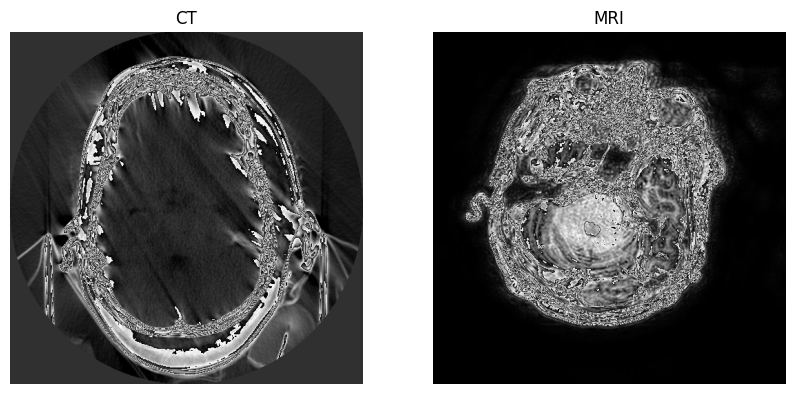

In [ ]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(x1[200].astype('uint8'))
plt.title("CT")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(x2[200].astype('uint8'))
plt.title("MRI")
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

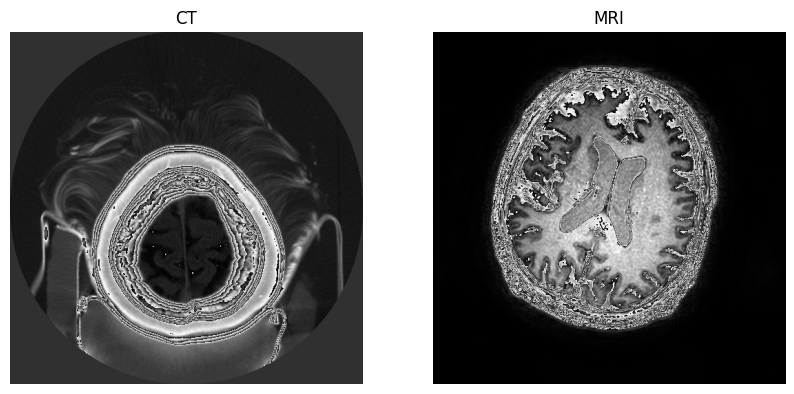

In [ ]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(x1[250].astype('uint8'))
plt.title("CT")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(x2[250].astype('uint8'))
plt.title("MRI")
plt.axis('off')

1D/grayscale image

(-0.5, 511.5, 511.5, -0.5)

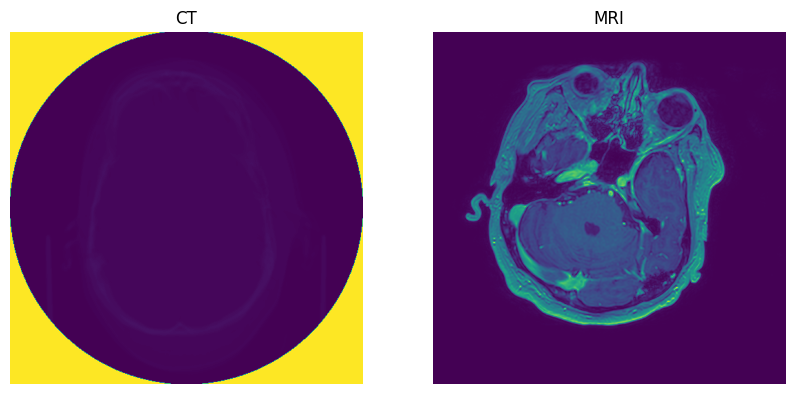

In [ ]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(x1[200][:,:,0])
plt.title("CT")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(x2[200][:, :,0])
plt.title('MRI')
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

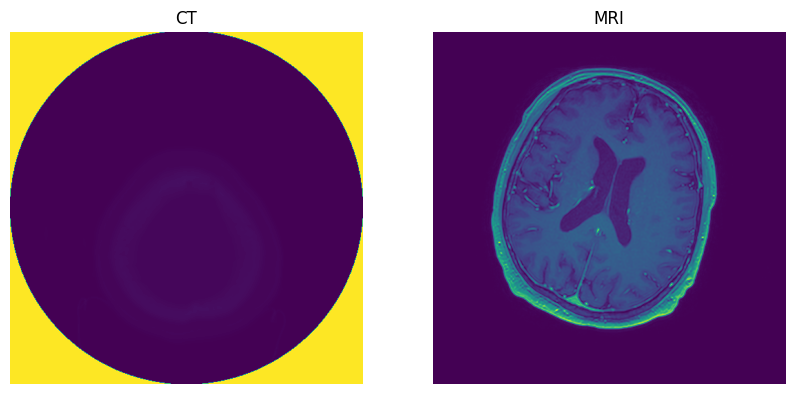

In [ ]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(x1[250][:, :,0])
plt.title("CT")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(x2[250][:, :,0])
plt.title("MRI")
plt.axis('off')

In [ ]:
!du -sh /drive/MyDrive/mri2ct_512.npz

du: cannot access '/drive/MyDrive/mri2ct_512.npz': No such file or directory
